# [**Interactive visualization of SARS-CoV2 outbreak in India**](https://github.com/MoadComputer/covid19-visualization/blob/master/examples/COVID19_India.ipynb)
## Author: [Dr. Rahul Remanan](https://www.linkedin.com/in/rahulremanan/), CEO [Moad Computer](https://moad.computer)
### Contact: rahul@moad.computer

This notebook creates an interactive visualization of the statewise SARS-CoV2 outbreak data in India using [GeoPandas](https://geopandas.org/) and [Bokeh](https://bokeh.org/).

The daily statewise SARS-CoV2 infection data is obtained from the [Ministry of Health and Family Welfare, India website](https://mohfw.gov.in), and cached in the [GitHub repo of this visualization and forecasting project](https://github.com/MoadComputer/covid19-visualization/).
## **[Run this notebook in Google Colab](https://colab.research.google.com/github/MoadComputer/covid19-visualization/blob/master/examples/Interactive_visualization_of_COVID19_in_India.ipynb)**

**(Update on 5th July, 2024: This interactive dashboard will no longer be updated due to a lack of publicly available SARS-CoV2 statewise case statistics from the [Indian government's ministry of health and family welfare website](https://mohfw.gov.in) that was serving as the data source for this application.)**

In [1]:
DATA_UPDATE_DATE='01-July-2024'
DATA_URL='https://github.com/MoadComputer/covid19-visualization/raw/main/data'

# Import libraries

In [2]:
import os, re, sys, math, json, bokeh, geopandas, numpy as np, pandas as pd

from packaging import version
from bokeh.io.doc import curdoc
from bokeh.layouts import layout
from bokeh.models.glyphs import Text
from scipy.interpolate import interp1d
from bokeh.application import Application
from bokeh.models.callbacks import CustomJS
from bokeh.plotting import show as plt_show
from bokeh.palettes import brewer,OrRd,YlGn
from bokeh.models.widgets import Button,Select
from bokeh.tile_providers import Vendors,get_provider
from bokeh.io import output_notebook,show,output_file
from bokeh.application.handlers import FunctionHandler
from bokeh.plotting import save, figure, output_file as out_file
from bokeh.models import ColumnDataSource, Slider, HoverTool, Select,Div,            \
                         Range1d, WMTSTileSource, BoxZoomTool, TapTool, Tabs
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, LegendItem, \
                         NumeralTickFormatter, LinearAxis,Grid,Label,Band, Legend

## **Conditional imports**

A few conditional imports for maintaining backwards compatibility with [Bokeh](https://bokeh.org/) visualization library APIs.

In [3]:
bokeh_version = bokeh.__version__ 
print('Generating SARS-CoV2 state-wise statistics overlay for India using Bokeh visualization library version: ', bokeh_version)

version_check = version.parse(bokeh_version) >= version.parse('3.4.1')
if version_check:
    from bokeh.models import TabPanel as Panel
    from bokeh.layouts import column
else:
    try:
        from bokeh.models import Panel
        from bokeh.layouts import column
    except ImportError:
        try:
            from bokeh.models import TabPanel as Panel
            from bokeh.models.layouts import Column as column
        except Exception as e:
            raise ImportError(f'Failed Bokeh imports due to: {e} ...')

Generating SARS-CoV2 state-wise statistics overlay for India using Bokeh visualization library version:  3.4.3


# Reading map data

In [4]:
India_statewise=geopandas.read_file(f'{DATA_URL}/GeoJSON_assets/India_statewise.geojson')

## Verifying all the states in the GeoJSON files

In [5]:
India_statewise['state']

0               Jammu and Kashmir
1                          Ladakh
2     Andaman and Nicobar Islands
3                       Telangana
4                  Andhra Pradesh
5               Arunachal Pradesh
6                           Assam
7                           Bihar
8                      Chandigarh
9                    Chhattisgarh
10         Dadra and Nagar Haveli
11                  Daman and Diu
12                          Delhi
13                            Goa
14                        Gujarat
15                        Haryana
16               Himachal Pradesh
17                      Jharkhand
18                      Karnataka
19                         Kerala
20                    Lakshadweep
21                 Madhya Pradesh
22                    Maharashtra
23                        Manipur
24                      Meghalaya
25                        Mizoram
26                       Nagaland
27                         Odisha
28                     Puducherry
29            

## Set map projection and summarize GeoJSON data

Map projections project the surface of the earth or a portion of it on a flat surface, such as a computer screen. Map projections approximate the earth's spherical shape (3D) onto a plane (2D). 

***Note: The use of projections doesn't mean that the earth is flat, but, on the contrary.***

The coordinate reference system (CRS) is used to define, using coordinates, the relationship between the two-dimensional, projected map in your GIS and the real places on the earth. The specific type of map projection and coordinate reference system to use, depends on the regional extent of the area you want to work in, on the analysis you want to do and often on the availability of data.[1](https://docs.qgis.org/3.10/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)

In this notebook, the EPSG:3395 CRS is used. It uses the elliptical version of the Marcator projection, with metre (m) as the measurement unit and [Greenwich](https://en.wikipedia.org/wiki/Greenwich) as the prime meridian. This system is useful for very small scale mapping, for parts of the world between 80°S and 84°N. This system excludes the polar areas.[2](https://epsg.io/3395)

In [6]:
India_statewise = India_statewise.to_crs("EPSG:3395")
India_statewise.head()

,state,geometry
0,Jammu and Kashmir,"POLYGON ((8248815.186 4158474.460, 8267604.320..."
1,Ladakh,"POLYGON ((8548889.055 3905752.225, 8536723.949..."
2,Andaman and Nicobar Islands,"MULTIPOLYGON (((10298818.467 1212439.225, 1030..."
3,Telangana,"POLYGON ((8935333.898 2108061.096, 8943036.679..."
4,Andhra Pradesh,"POLYGON ((8628301.070 1783835.012, 8660560.315..."


## Fix naming issues with Indian states

In [7]:
def apply_corrections(input_df):
  for state in list(input_df['state'].values):
    input_df.loc[input_df['state']==state,'state']=re.sub('[^A-Za-z ]+', '',str(state))
  input_df.loc[input_df['state']=='Karanataka','state']='Karnataka' 
  input_df.loc[input_df['state']=='Himanchal Pradesh','state']='Himachal Pradesh' 
  input_df.loc[input_df['state']=='Telengana','state']='Telangana'  
  input_df.loc[input_df['state']=='Dadra and Nagar Haveli','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Dadar Nagar Haveli','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Dadra Nagar Haveli','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Daman & Diu','state']='Dadra and Nagar Haveli and Daman and Diu'
  input_df.loc[input_df['state']=='Daman and Diu','state']='Dadra and Nagar Haveli and Daman and Diu'
  return input_df

In [8]:
India_statewise=apply_corrections(India_statewise)
India_statewise.head()

,state,geometry
0,Jammu and Kashmir,"POLYGON ((8248815.186 4158474.460, 8267604.320..."
1,Ladakh,"POLYGON ((8548889.055 3905752.225, 8536723.949..."
2,Andaman and Nicobar Islands,"MULTIPOLYGON (((10298818.467 1212439.225, 1030..."
3,Telangana,"POLYGON ((8935333.898 2108061.096, 8943036.679..."
4,Andhra Pradesh,"POLYGON ((8628301.070 1783835.012, 8660560.315..."


# Read statewise SARS-CoV2 infection data

In [9]:
covid19_data=pd.read_csv(f'{DATA_URL}/Coronavirus_stats/India/COVID19_India_statewise.csv')

In [10]:
covid19_data=apply_corrections(covid19_data)
covid19_data.head()

,ID,state,total_cases,discharged,deaths,active_cases
0,1,Andaman and Nicobar Islands,10766,10637,129,0
1,2,Andhra Pradesh,2341097,2326364,14733,0
2,3,Arunachal Pradesh,67049,66753,296,0
3,4,Assam,746244,738206,8037,1
4,5,Bihar,855691,843376,12315,0


In [11]:
noCOVID19_list = list(set(list(India_statewise.state.values)) -set(list(covid19_data.state)))
print('A total of: {} states with no reports of COVID19 ...'.format(len(noCOVID19_list)))
if len(noCOVID19_list)>=1:
  print('\nStates in India with no COVID19 reports:')  
  for noCOVID19_state in noCOVID19_list:
    print('\n{} ...'.format(noCOVID19_state))

A total of: 0 states with no reports of COVID19 ...


# Combine geographical and SARS-CoV2 statewise statistics


The function: ``` covid19_json(covid_df, geo_df) ``` combines the COVID19 dataframe and the GeoPandas dataframe. The output is a dictionary that returns: ```{'json_data': json_data, 'data_frame': merged_df}```

In [12]:
def covid19_json(covid_df, geo_df,verbose=False):
    merged_df = pd.merge(geo_df, covid_df, on='state', how='left')

    try:
      merged_df = merged_df.fillna(0)
    except:
      merged_df.fillna({'total_cases': 0}, inplace=True)
      merged_df.fillna({'deaths': 0}, inplace=True)
      merged_df.fillna({'discharged': 0}, inplace=True)
      if verbose:
        print('Consider updating GeoPandas library ...')
    
    merged_json = json.loads(merged_df.to_json())
    json_data = json.dumps(merged_json)
    return {'json_data': json_data, 'data_frame': merged_df}

In [13]:
merged_data = covid19_json(covid19_data, India_statewise, verbose=True)
merged_json = merged_data['json_data']

<Axes: >

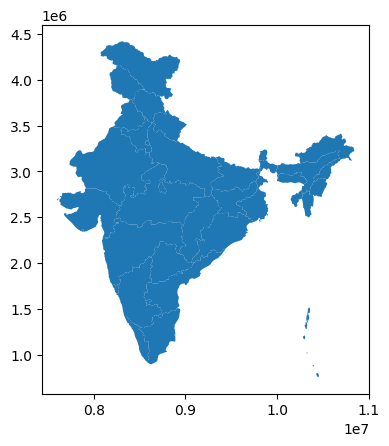

In [14]:
merged_data['data_frame'].plot()

# Visualization of statewise SARS-CoV2 outbreak in India 

## Helper functions for plotting statewise SARS-CoV2 statistics

In [15]:
def CustomPalette(palette_type, enable_colorInverse=True):
  if (palette_type.lower()=='OrRd'.lower()) or (palette_type.lower()=='reds'):
    palette = OrRd[9]
  elif (palette_type.lower()=='YlGn'.lower()) or (palette_type.lower()=='greens'):
    palette = YlGn[9]
  else:
    palette = brewer['Oranges']
    
  if enable_colorInverse:
    palette = palette[::-1]
  else:
    palette = palette[::1]
  return palette

def CustomHoverTool():
  simpleStats_hover = HoverTool(tooltips =
    """<strong><font face="Arial" size="3">@state</font></strong> <br>
      <font face="Arial" size="3">Cases: @total_cases{}</font><br>
      <font face="Arial" size="3">Deaths: @deaths{} </font>
      <hr>
      <strong><font face="Arial" size="1">Updated on: {}</font></strong><br>
      <strong><font face="Arial" size="1">Data from: <a>https://mohfw.gov.in</a> </font></strong>
                                        """.format('{(0,0)}', 
                                                   '{(0,0)}',
                                                   DATA_UPDATE_DATE))
  return simpleStats_hover

def MapOverlayFormatter(map_overlay):
  if map_overlay:
    xmin, xmax = 7570000, 10950000
    ymin, ymax = 890000, 4850000
    return xmin, xmax, ymin, ymax

def geographic_overlay(plt, geosourceJson=None, colorBar=None,
                       colorMapper=None, colorMode='', hoverTool=None,
                       mapOverlay=True, enableTapTool=False, enableToolbar=True):
  if mapOverlay:
    wmts = WMTSTileSource(url="https://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png")
    plt.add_tile(wmts)
    plt.xaxis.axis_label = 'longitude'
    plt.yaxis.axis_label = 'latitude'
  
  plt.xgrid.grid_line_color = None
  plt.ygrid.grid_line_color = None
  plt.axis.visible = False
  plt.patches('xs','ys', 
              source = geosourceJson, 
              fill_color = {'field' : colorMode, 
                            'transform' : colorMapper},
              line_color = 'purple', 
              line_width = 0.5, 
              fill_alpha = 0.60 if enableTapTool else 0.65,
              nonselection_alpha = 0.65)
  plt.add_layout(colorBar, 'right')
  plt.add_tools(hoverTool)
  if enableTapTool:
    plt.add_tools(TapTool())
  if enableToolbar:
    plt.toolbar.autohide = True
  if plt.title is not None:
    plt.title.text_font_size = '30pt'
  return plt

def lakshadweep_correction(plt, input_df=None):
  source = ColumnDataSource(data=dict(
        x=[8075000], y=[1250000], state=['Lakshadweep'],
        total_cases=[input_df.loc[input_df['state']=='Lakshadweep','total_cases']],
        deaths=[input_df.loc[input_df['state']=='Lakshadweep','deaths']]))

  if version_check:
    plot_circle = plt.scatter
  else:
    plot_circle = plt.circle

  plot_circle(x='x', y='y', 
              size=25, 
              source=source,
              line_color='purple', 
              color='blue',
              fill_alpha=0.075, 
              nonselection_alpha=0.20)
  return plt

def CustomTitleFormatter():
  xtext, ytext = 8350000, 4425000
  xbox, ybox = 9450000, 4575000
  return xtext, ytext, xbox, ybox

def CustomTitleOverlay(plt, xtext=0, ytext=0,
                       xbox=0, ybox=0, input_df=None):
  
  overlayText=Label(x=xtext, y=ytext, 
                    text="COVID19 in India",
                    text_font_size='28.5pt')
    
  plt.add_layout(overlayText) 

  source = ColumnDataSource(data=dict(x=[xbox], y=[ybox], state=['India'],
                                      total_cases=[input_df['total_cases'].sum()],
                                      deaths=[input_df['deaths'].sum()]))

  plt.rect(x='x', y='y', width=2250000, height=250000, 
           color="#CAB2D6", source=source, line_color='purple',
           #width_units='screen', height_units='screen',
           fill_alpha=0.25)
  return plt

    
def covid19_plot(covid19_geosource, input_df=None, input_field=None,
                 color_field='total_cases', plot_title=None,
                 map_overlay=True, palette_type='OrRd', integer_plot=False,
                 custom_hovertool=True, enable_LakshadweepStats=True,
                 enable_IndiaStats=False, enable_toolbar=False):
  
  palette = CustomPalette(palette_type, enable_colorInverse=True)
  color_mapper = LinearColorMapper(palette=palette, low=0, 
                                   high=np.round(
                                       (np.max(input_df[color_field].values)),3)) 
  if integer_plot:
    format_tick=NumeralTickFormatter(format='0,0')
  else:
    format_tick=NumeralTickFormatter(format=str(np.round(
        (input_df[input_field].values.astype('float')),1)))
  color_bar = ColorBar(color_mapper=color_mapper, 
                       label_standoff=14, 
                       formatter=format_tick,
                       border_line_color=None, 
                       major_label_text_font_size='12px',
                       location = (0, 0))
  xmin,xmax,ymin,ymax=MapOverlayFormatter(map_overlay)
  hover=CustomHoverTool()

  plt=figure(title = plot_title,
             x_range=(xmin, xmax) if map_overlay else None,
             y_range=(ymin, ymax) if map_overlay else None,
             tools='save' if enable_toolbar else '', 
             min_height = 480, min_width = 480,
             toolbar_location = 'left' if enable_toolbar else None,
             lod_factor=int(1e7), lod_threshold=int(2),
             # output_backend="webgl"
            ) 
        
  plt=geographic_overlay(plt, geosourceJson=covid19_geosource,
                         colorBar=color_bar, colorMapper=color_mapper, colorMode=input_field,
                         hoverTool=hover, mapOverlay=map_overlay, enableToolbar=enable_toolbar,
                         enableTapTool=False)
  
  if enable_LakshadweepStats:
    plt=lakshadweep_correction(plt, input_df=input_df)

  if enable_IndiaStats:
    xtext,ytext,xbox,ybox=CustomTitleFormatter()
    plt=CustomTitleOverlay(plt, xtext=xtext, ytext=ytext,
                           xbox=xbox, ybox=ybox, input_df=input_df)
  plt.xaxis.major_tick_line_color=None  
  plt.yaxis.major_tick_line_color=None
  plt.xaxis.minor_tick_line_color=None 
  plt.yaxis.minor_tick_line_color=None 
  plt.xaxis[0].ticker.num_minor_ticks=0
  plt.yaxis[0].ticker.num_minor_ticks=0
  plt.yaxis.formatter=NumeralTickFormatter(format='0,0')
  return plt

## Create interactive plot using Bokeh

In [16]:
covid19_geosource=GeoJSONDataSource(geojson=merged_json)
plot_title='COVID19 outbreak in India'
app_title='COVID19 India'

India_totalCases=covid19_data['total_cases'].sum()
India_totalDeaths=covid19_data['deaths'].sum()
print(India_totalCases)

basic_covid19_plot = covid19_plot(covid19_geosource, input_df=covid19_data,
                                  input_field='total_cases', color_field='total_cases',
                                  enable_IndiaStats=True, integer_plot=True,
                                  plot_title=plot_title)

curdoc().title=app_title
basic_covid19_layout = column(basic_covid19_plot)
curdoc().add_root(basic_covid19_layout)

45040752


## [Display the interactive plot](https://moad.computer/app/India_COVID19.html)

In [17]:
output_notebook()
show(basic_covid19_layout)

Loading BokehJS ...

In [18]:
out_file('India_COVID19.html')
save(basic_covid19_layout)

'/kaggle/working/India_COVID19.html'